# DEA Waterbodies: Collection 3

This notebook compares DEA Waterbodies Collection 2 and Collection 3. There are three runs we can look at:

- Collection 2 on 25m pixels,
- Collection 3 on 25m pixels, and
- Collection 3 on 30m pixels.

We need to compare these and find any significant differences.

In [92]:
import sys
import warnings
from pathlib import Path

import datacube
import geopandas as gpd
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats
from IPython.display import Image, display
from matplotlib import pyplot as plt
from scipy.stats import distributions
from tqdm.notebook import tqdm

sys.path.append("../Scripts")
from dea_bandindices import calculate_indices
from dea_datahandling import load_ard
from dea_plotting import rgb, xr_animation

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (6, 4)

In [2]:
dc = datacube.Datacube(app="c3-waterbodies")

In [3]:
waterbodies_path = Path(
    "/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/C3/"
)
c2_25_path = waterbodies_path / "timeseries_aus_c2_25m"
c3_25_path = waterbodies_path / "timeseries_aus_c3_25m"
c3_30_path = waterbodies_path / "timeseries_aus_c3_30m"

In [4]:
wbs = gpd.read_file(waterbodies_path / "Waterbodies_C3_subset.shp").set_index("UID")

Ness also generated some statistics for these waterbodies, which we will also load.

In [5]:
stats_comp = pd.read_csv(waterbodies_path / "c2_c3_comparison.csv").set_index("UID")
stats_comp.columns = stats_comp.columns.str.strip()

## Plotting basic stats

Let's start by visualising Ness' statistics to see the difference between the two collections.

In [6]:
stat_names = {
    "mean wet pixel percentage": "{}_Wet_pixel_percentage_mean",
    "mean number of wet pixels": "{}_num_wet_pixels_mean",
    "total number of pixels": "{}_total_num_pix",
    "number of valid observations": "num_valid_obs_{}",
}

In [7]:
stat_columns = {
    stat_name: {fm: stat_col.format(fm) for fm in ["c2_25m", "c3_25m", "c3_30m"]}
    for stat_name, stat_col in stat_names.items()
}

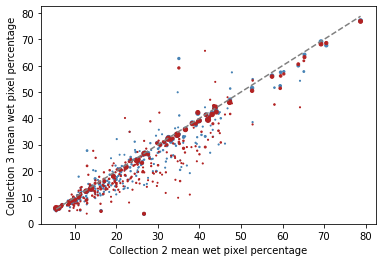

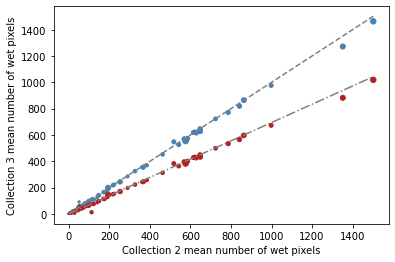

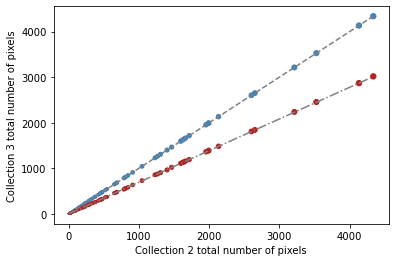

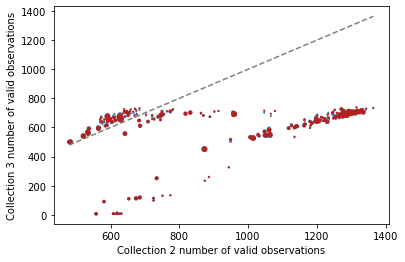

In [8]:
for name, cols in stat_columns.items():
    plt.figure()
    c2 = stats_comp[cols["c2_25m"]]
    c3_25 = stats_comp[cols["c3_25m"]]
    c3_30 = stats_comp[cols["c3_30m"]]
    s = np.sqrt(stats_comp["c2_25m_total_num_pix"] / 5)
    plt.scatter(c2, c3_25, label="C3 25m", c="steelblue", s=s)
    plt.scatter(c2, c3_30, label="C3 30m", c="firebrick", s=s)
    min_, max_ = c2.min(), c2.max()
    plt.plot([min_, max_], [min_, max_], c="grey", linestyle="--")
    if "num" in name and "pix" in name:
        plt.plot(
            [min_, max_],
            [min_ * (25 / 30) ** 2, max_ * (25 / 30) ** 2],
            c="grey",
            linestyle="-.",
        )
    plt.xlabel(f"Collection 2 {name}")
    plt.ylabel(f"Collection 3 {name}")
    plt.show()

The number of pixels and mean number of wet pixels both line up pretty well. The mean wet pixel percentage lines up well too, but with a fair bit of scatter (this should be fine - I think it comes from the fact that the scatter in number-of-wet-pixels is low, and this is backed up by the fact that the percentage is more variable for smaller waterbodies).

## Loading the CSVs

Now we'll load the full time series for each collection.

In [10]:
c2_25 = {}
for p in c2_25_path.iterdir():
    for q in p.iterdir():
        name = q.stem
        if not q.suffix == ".csv":
            continue
        c2_25[name] = pd.read_csv(q).set_index("Observation Date")
        c2_25[name].columns = ["pc_wet", "px_wet"]
        c2_25[name].index = pd.to_datetime(c2_25[name].index)

c3_25 = {}
for p in c3_25_path.iterdir():
    for q in p.iterdir():
        name = q.stem
        if not q.suffix == ".csv":
            continue
        c3_25[name] = pd.read_csv(q).set_index("Observation Date")
        c3_25[name].columns = ["pc_wet", "px_wet"]
        c3_25[name].index = pd.to_datetime(c3_25[name].index)

c3_30 = {}
for p in c3_30_path.iterdir():
    for q in p.iterdir():
        name = q.stem
        if not q.suffix == ".csv":
            continue
        c3_30[name] = pd.read_csv(q).set_index("Observation Date")
        c3_30[name].columns = ["pc_wet", "px_wet"]
        c3_30[name].index = pd.to_datetime(c3_30[name].index)

In [11]:
uids = sorted(c2_25)

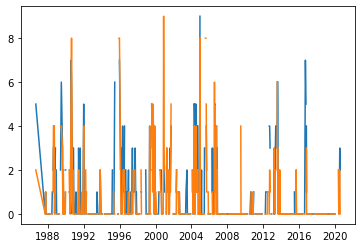

In [12]:
k = 1
plt.plot(c2_25[uids[k]].index, c2_25[uids[k]].px_wet)
plt.plot(c3_25[uids[k]].index, c3_25[uids[k]].px_wet)

## Least-squares error

We can also look at the least-squares error between C2 and C3, for those with overlapping observations. It seems like C3 has a stricter cloud mask than C2, so we should have less observations, but the ones we do have should align.

In [13]:
lses_pc = []
lses_px = []
for uid in uids:
    c2 = c2_25[uid].resample("1D").mean()
    c3 = c3_25[uid].resample("1D").mean()
    lse = np.sqrt(np.mean((c2.pc_wet - c3.pc_wet) ** 2))
    lses_pc.append(lse)
    lse = np.sqrt(np.mean((c2.px_wet - c3.px_wet) ** 2))
    lses_px.append(lse)

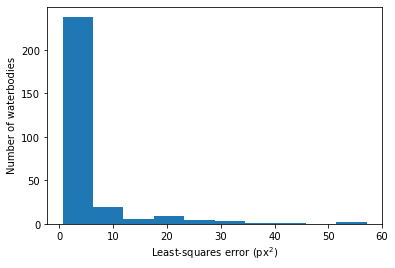

In [14]:
plt.hist(lses_px)
plt.xlabel("Least-squares error (px$^2$)")
plt.ylabel("Number of waterbodies");

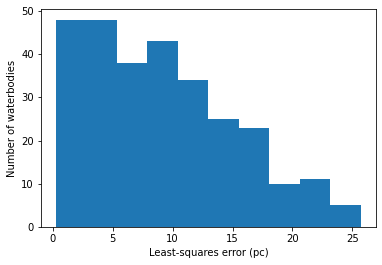

In [15]:
plt.hist(lses_pc)
plt.xlabel("Least-squares error (pc)")
plt.ylabel("Number of waterbodies");

We already know that the percentage is noisier, so it isn't too surprising that the spread of the MSE is higher for percentages than for pixels. Some of the differences are very high, however, and it would be useful to investigate which objects this is the case for.

Repeating this for C3 30m:

In [17]:
lses_pc_30 = []
lses_px_30 = []
for uid in uids:
    c2 = c2_25[uid].resample("1D").mean()
    c3 = c3_30[uid].resample("1D").mean()
    lse = np.sqrt(np.mean((c2.pc_wet - c3.pc_wet) ** 2))
    lses_pc_30.append(lse)
    lse = np.sqrt(np.mean((c2.px_wet - c3.px_wet * (25 / 30) ** 2) ** 2))
    lses_px_30.append(lse)

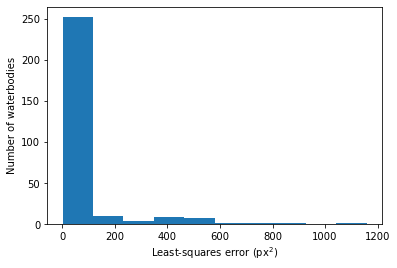

In [20]:
plt.hist(lses_px_30)
plt.xlabel("Least-squares error (px$^2$)")
plt.ylabel("Number of waterbodies");

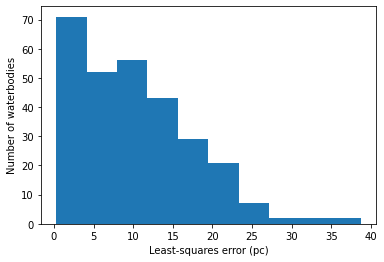

In [21]:
plt.hist(lses_pc_30)
plt.xlabel("Least-squares error (pc)")
plt.ylabel("Number of waterbodies");

## Dynamic time warping distance

There is also the possibility that the observations are a little offset or something like that, which would give unusually high LSEs. We can use DTW to get around this.

In [23]:
# pip install dtw-python

In [22]:
import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [24]:
dists_pc = []
for uid in tqdm(uids):
    c3 = c3_25[uid].pc_wet.values
    c2 = c2_25[uid].pc_wet.values
    c3 = c3[~pd.isnull(c3)]
    c2 = c2[~pd.isnull(c2)]
    dist = dtw.dtw(c3, c2, distance_only=True).normalizedDistance
    dists_pc.append(dist)

In [149]:
dists_px = []
for uid in tqdm(uids):
    c3 = c3_25[uid].px_wet.values
    c2 = c2_25[uid].px_wet.values
    c3 = c3[~pd.isnull(c3)]
    c2 = c2[~pd.isnull(c2)]
    dist = dtw.dtw(c3, c2, distance_only=True).normalizedDistance
    dists_px.append(dist)

In [150]:
dists_px_30 = []
for uid in tqdm(uids):
    c3 = c3_30[uid].px_wet.values
    c2 = c2_25[uid].px_wet.values
    c3 = c3[~pd.isnull(c3)]
    c2 = c2[~pd.isnull(c2)]
    dist = dtw.dtw(c3, c2, distance_only=True).normalizedDistance
    dists_px_30.append(dist)

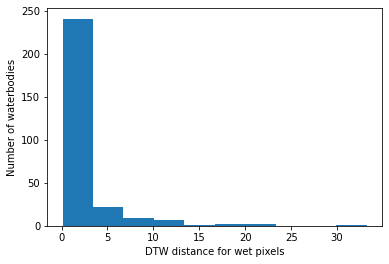

In [26]:
plt.hist(dists_px)
plt.xlabel("DTW distance for wet pixels (25m)")
plt.ylabel("Number of waterbodies");

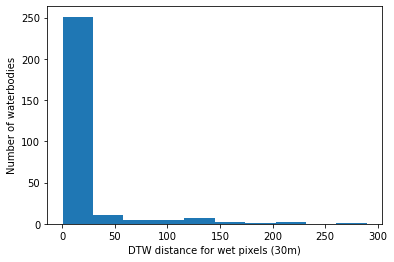

In [151]:
plt.hist(dists_px_30)
plt.xlabel("DTW distance for wet pixels (30m)")
plt.ylabel("Number of waterbodies");

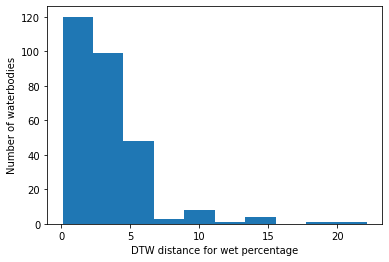

In [27]:
plt.hist(dists_pc)
plt.xlabel("DTW distance for wet percentage")
plt.ylabel("Number of waterbodies");

## Variance vs discrepancy

One possibility is that highly varying waterbodies are different between C2 and C3 purely because they vary so much, and the slight differences in cloud masking (or whatever) throw us off. Let's plot standard deviation against our distance measures.

In [28]:
c2_variance = [np.std(c2_25[u].px_wet) for u in uids]

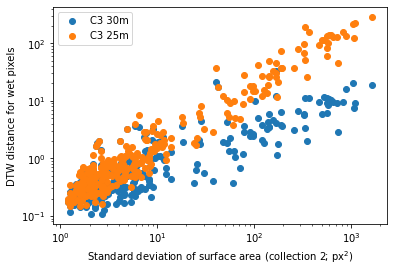

In [152]:
plt.scatter(c2_variance, dists_px)
plt.scatter(c2_variance, dists_px_30)
plt.xlabel("Standard deviation of surface area (collection 2; px$^2$)")
plt.ylabel("DTW distance for wet pixels")
plt.yscale("log")
plt.xscale("log")
plt.legend(['C3 30m', 'C3 25m']);

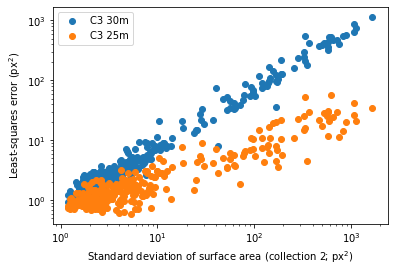

In [142]:
plt.scatter(c2_variance, lses_px_30)
plt.scatter(c2_variance, lses_px)
plt.xlabel("Standard deviation of surface area (collection 2; px$^2$)")
plt.ylabel("Least-squares error (px$^2$)")
plt.yscale("log")
plt.xscale("log")
plt.legend(['C3 30m', 'C3 25m'])

This makes sense! In fact, the LSE is essentially measuring the standard deviation of the surface area (note that they are in the same units). This means that the discrepancy is likely entirely explained through noise. The 30m and 25m are pretty different though which is weird.

## Properties of missing or added data

Are the data points that are dropped by C3 particularly wet?

In [123]:
c2_where_c3_missing = []
c3_where_c2_missing = []
for u in uids:
    c2 = c2_25[u]
    c3 = c3_25[u]
    joined = c2.join(c3, lsuffix="_c2", rsuffix="_c3", how="outer")
    missing_c2 = pd.isnull(joined.pc_wet_c2)
    missing_c3 = pd.isnull(joined.pc_wet_c3)
    c2_where_c3_missing.append(
        (joined[missing_c3 & ~missing_c2].pc_wet_c2 - joined.pc_wet_c2.mean()).mean()
    )
    c3_where_c2_missing.append(
        (joined[missing_c2 & ~missing_c3].pc_wet_c3 - joined.pc_wet_c3.mean()).mean()
    )

In [124]:
c2_where_c3_missing = np.array(c2_where_c3_missing)
c2_where_c3_missing = c2_where_c3_missing[~np.isnan(c2_where_c3_missing)]

In [125]:
c3_where_c2_missing = np.array(c3_where_c2_missing)
c3_where_c2_missing = c3_where_c2_missing[~np.isnan(c3_where_c2_missing)]

In [126]:
bins = np.linspace(-10, 10, 100)

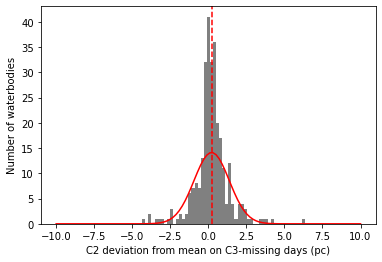

In [127]:
loc_c2c3, scale_c2c3 = distributions.norm.fit(c2_where_c3_missing)
dist_c2c3 = distributions.norm(loc=loc_c2c3, scale=scale_c2c3)
hist = plt.hist(c2_where_c3_missing, bins=bins, color="grey")
plt.plot(bins, dist_c2c3.pdf(bins) * hist[0].max(), c="red")
plt.axvline(np.nanmean(c2_where_c3_missing), c="red", linestyle="--")
plt.xlabel("C2 deviation from mean on C3-missing days (pc)")
plt.ylabel("Number of waterbodies");

C3 missing days tend to have _slightly_ higher surface areas. Is this significant?

In [128]:
scipy.stats.ttest_1samp(c2_where_c3_missing, 0)

Ttest_1sampResult(statistic=3.1355088037937726, pvalue=0.0018954542511445613)

This _is_ significant at the 0.2% level.

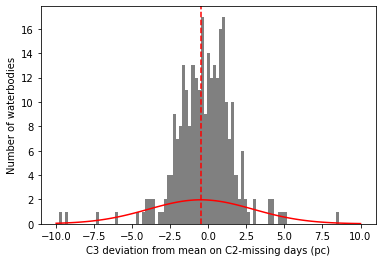

In [129]:
loc_c3c2, scale_c3c2 = distributions.norm.fit(c3_where_c2_missing)
dist_c3c2 = distributions.norm(loc=loc_c3c2, scale=scale_c3c2)
hist = plt.hist(c3_where_c2_missing, bins=bins, color="grey")
plt.plot(bins, dist_c3c2.pdf(bins) * hist[0].max(), c="red")
plt.axvline(np.mean(c3_where_c2_missing), c="red", linestyle="--")
plt.xlabel("C3 deviation from mean on C2-missing days (pc)")
plt.ylabel("Number of waterbodies");

The spread for the deviation on newly-added days in C3 is way higher. The mean is slightly non-zero, but again, is this significant?

In [130]:
scipy.stats.ttest_1samp(c3_where_c2_missing, 0)

Ttest_1sampResult(statistic=-2.427759699938795, pvalue=0.01581614941098832)

This _is_ significant at the 2% level (so less significant than the converse). The waterbodies are slightly _drier_ on days where C2 did not record an observation but C3 did. Let's finish up by repeating this analysis for C3 30m.

In [131]:
c2_where_c3_missing = []
c3_where_c2_missing = []
for u in uids:
    c2 = c2_25[u]
    c3 = c3_30[u]
    joined = c2.join(c3, lsuffix="_c2", rsuffix="_c3", how="outer")
    missing_c2 = pd.isnull(joined.pc_wet_c2)
    missing_c3 = pd.isnull(joined.pc_wet_c3)
    c2_where_c3_missing.append(
        (joined[missing_c3 & ~missing_c2].pc_wet_c2 - joined.pc_wet_c2.mean()).mean()
    )
    c3_where_c2_missing.append(
        (joined[missing_c2 & ~missing_c3].pc_wet_c3 - joined.pc_wet_c3.mean()).mean()
    )

In [132]:
c2_where_c3_missing = np.array(c2_where_c3_missing)
c2_where_c3_missing = c2_where_c3_missing[~np.isnan(c2_where_c3_missing)]

In [133]:
c3_where_c2_missing = np.array(c3_where_c2_missing)
c3_where_c2_missing = c3_where_c2_missing[~np.isnan(c3_where_c2_missing)]

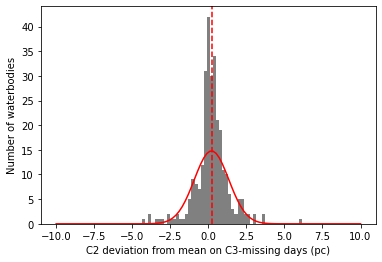

In [136]:
loc_c2c3, scale_c2c3 = distributions.norm.fit(c2_where_c3_missing)
dist_c2c3 = distributions.norm(loc=loc_c2c3, scale=scale_c2c3)
hist = plt.hist(c2_where_c3_missing, bins=bins, color="grey")
plt.plot(bins, dist_c2c3.pdf(bins) * hist[0].max(), c="red")
plt.axvline(np.nanmean(c2_where_c3_missing), c="red", linestyle="--")
plt.xlabel("C2 deviation from mean on C3-missing days (pc)")
plt.ylabel("Number of waterbodies");

In [137]:
scipy.stats.ttest_1samp(c2_where_c3_missing, 0)

Ttest_1sampResult(statistic=3.1254627925535354, pvalue=0.0019591429153914598)

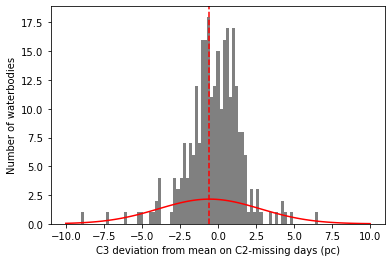

In [139]:
loc_c3c2, scale_c3c2 = distributions.norm.fit(c3_where_c2_missing)
dist_c3c2 = distributions.norm(loc=loc_c3c2, scale=scale_c3c2)
hist = plt.hist(c3_where_c2_missing, bins=bins, color="grey")
plt.plot(bins, dist_c3c2.pdf(bins) * hist[0].max(), c="red")
plt.axvline(np.mean(c3_where_c2_missing), c="red", linestyle="--")
plt.xlabel("C3 deviation from mean on C2-missing days (pc)")
plt.ylabel("Number of waterbodies");

In [140]:
scipy.stats.ttest_1samp(c3_where_c2_missing, 0)

Ttest_1sampResult(statistic=-2.8184759126271284, pvalue=0.005164297707879992)

## Examining highly deviant waterbodies

Some waterbodies have quite high discrepancies between C2 and C3. Let's look at them.

In [232]:
deviants = np.argsort(lses_px)[::-1][:10]

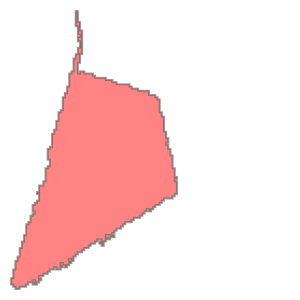

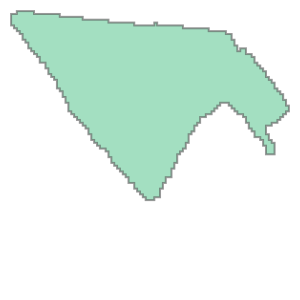

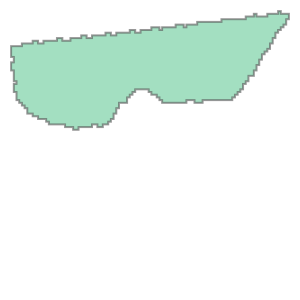

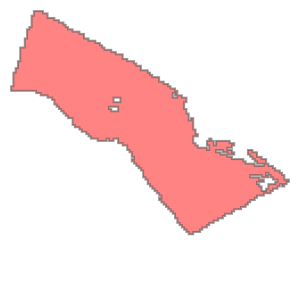

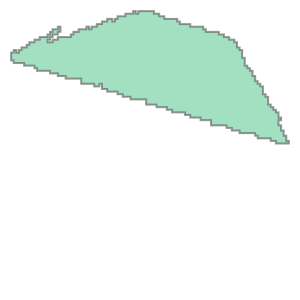

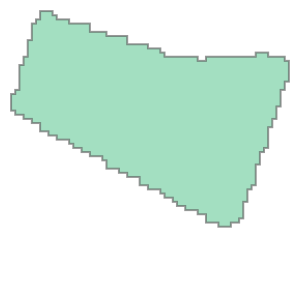

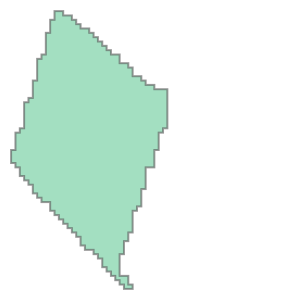

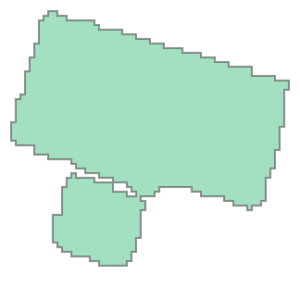

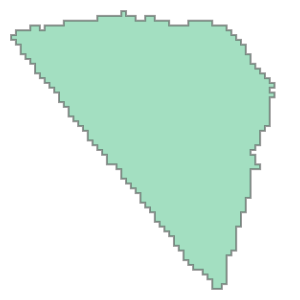

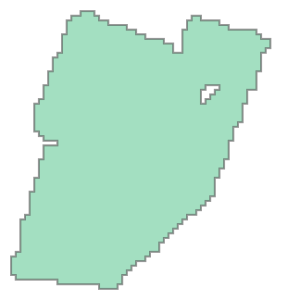

In [233]:
for deviant in deviants:
    display(wbs.loc[uids[deviant]].geometry)

In [227]:
def view_wb(uid):
    waterbody = wbs.loc[uid]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ds = load_ard(
            dc,
            ["ga_ls8c_ard_3"],
            measurements=["red", "green", "blue"],
            min_gooddata=0.90,
            geopolygon=datacube.utils.geometry.Geometry(
                waterbody.geometry.buffer(100), crs="EPSG:3577"
            ),
            output_crs="EPSG:3577",
            resolution=(-25, 25),
        )
    xr_animation(
        ds=ds,
        bands=["red", "green", "blue"],
        output_path="animated_timeseries.gif",
        interval=100,
        width_pixels=300,
    )

    # Plot animated gif
    plt.close()
    return Image(filename="animated_timeseries.gif")

In [157]:
n_valid_c2 = [pd.notnull(c2_25[u].pc_wet).sum() for u in uids]
n_valid_c3 = [pd.notnull(c3_25[u].pc_wet).sum() for u in uids]

Text(0, 0.5, 'Number of observations in C3')

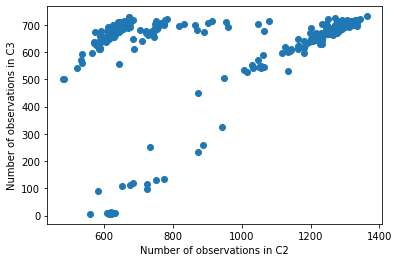

In [164]:
plt.scatter(n_valid_c2, n_valid_c3)
plt.xlabel('Number of observations in C2')
plt.ylabel('Number of observations in C3')

In [159]:
diff = np.array(n_valid_c2) - n_valid_c3

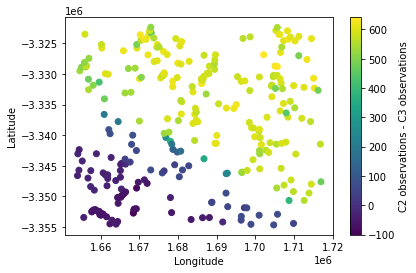

In [163]:
plt.scatter(wbs.centroid.x, wbs.centroid.y, c=diff)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='C2 observations - C3 observations')